In [1]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict
from _constants import LLM_CONFIGS
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from typing_extensions import Literal
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver


# Example - Prompt Chaining

In [2]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [3]:
llm = ChatOllama(
    model=LLM_CONFIGS["llama3.2"]["model"]
)

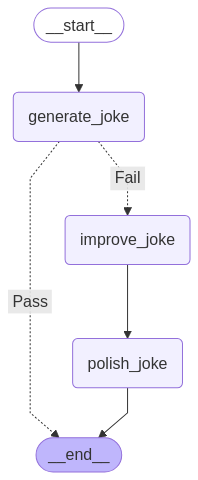

In [4]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


In [ ]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [5]:
# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")


Initial joke:
Why did the cat join a band?

Because it wanted to be the purr-cussionist.

--- --- ---

Improved joke:
Here's an attempt at adding wordplay:

Why did the cat join a band?

Because it heard the drums were 'paw-some' and wanted to become the purr-cussionist – but little did it know, it was just the cat's meow on stage!

In this version, I've added a few layers of wordplay:

1. "Paw-some" is a play on the word "awesome" that incorporates the idea of a cat's paw.
2. The phrase "the cat's meow" is an idiom that means something or someone is excellent or desirable, but in this context, it's also a clever pun on the fact that cats are known for their distinctive meowing sound.

Let me know if you'd like me to try any further adjustments!

--- --- ---

Final joke:
I love where you're going with this joke. Here's a suggestion for adding another layer of wordplay:

Why did the cat join a band?

Because it heard the drums were 'paw-some' and wanted to become the purr-cussionist – b

# Rough RRA Workflow - Prompt Chaining

In [12]:
# memory = MemorySaver()

In [2]:
# Graph state
class State(TypedDict):
    user_proposal: str
    risk_assessment_and_rating: str
    proposal_feedback: str
    improved_proposal: str
    pass_or_fail: str

In [3]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["pass", "fail"] = Field(
        description="Decide if the proposal passes and will be successful going through FDA review. If the rating is higher than 9 out of 10, then it passes, else it fails.",
    )
    feedback: str = Field(
        description="If the proposal fails, provide the current rating and risk assessment to improve.",
    )


In [4]:
llm = ChatOllama(
    model=LLM_CONFIGS["llama3.2"]["model"]
)
evaluator = llm.with_structured_output(Feedback)

In [23]:
# # Schema for structured output to use as routing logic
# class Route(BaseModel):
#     step: Literal["poem", "story", "joke"] = Field(
#         None, description="The next step in the routing process"
#     )

In [24]:
# router = llm.with_structured_output(Route)


In [25]:
# def get_results_from_vector_db():
#     return "result1, result2, result3"

# def get_results_from_clinicaltrials_api():
#     return "trial1, trial2, trial3"

In [5]:
# Nodes
def risk_assessment(state: State, config: RunnableConfig):
    """First LLM call to provide a risk assessment of the user proposal"""
    risk_assessment_system_message = "You are a FDA regulatory reviewer. Provide a risk \
                    assessment of the user submission and detail specific flaws in the application\
                        that would not pass regulatory approval. Provide an overall summary and a rating \
                            from 1 to 10."

    if state.get("improved_proposal"):
        grade = evaluator.invoke(
            [
                SystemMessage(content= risk_assessment_system_message),
                HumanMessage(content=f"Review this proposal, provide a rating, and grade the proposal: {state['improved_proposal']} but take into account the feedback: {state['proposal_feedback']}")
            ],
            config
        )
    #else:
    #    msg = llm.invoke(f"Write a joke about {state['topic']}")
    #return {"joke": msg.content}
    else:
        grade = evaluator.invoke(
            [
                SystemMessage(content= risk_assessment_system_message),
                HumanMessage(content=f"Review this proposal, provide a rating, and grade the proposal: {state['user_proposal']}")
            ],
            config
        )
    
    return {"pass_or_fail":grade.grade, "risk_assessment_and_rating": grade.feedback}


# need to be removed? part of evaluator
def check_rating(state: State):
    """Gate function to check if the risk rating is = 5 out of 10"""

    # Simple check - does the joke contain "?" or "!"
    if "5" in state["risk_assessment_and_rating"]:
        return "Fail"
    return "Pass"


def regulatory_risk_critquer(state: State, config: RunnableConfig):
    """Second LLM call to provide specific feedback based on different categories of regulatory approval to improve the rating."""

    #msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    msg = llm.invoke(
        [
            SystemMessage(content="You are an expert regulatory critiquer. \
                            Given the risk assessment and rating, propose \
                                changes and explain why to make these changes to improve the original proposal.\
                                Also provide an alternative approach for how they can rework their proposal to a different population or other strategies you can think of for better success \
                                    Give the final result in bullet points summary for each of these categories. \
                                    1) Mechanistic Risk 2) Biomarker Asessment 3) Endpoint Alignment 4) Safety."),
            HumanMessage(content=f"Here is the original proposal: {state['user_proposal']}. Here is the risk assessment \
                and rating: {state['risk_assessment_and_rating']}")
        ],
        config
    )
    return {"proposal_feedback": msg.content}


def proposal_writer(state: State, config: RunnableConfig):
    """Third LLM call for writing a new proposal based on feedback."""

    #msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    msg = llm.invoke(
        [
            SystemMessage(content="You are an expert FDA regulatory writer. \
                            Given the feedback for approval, rewrite the original proposal with the appropriate changes. \
                                Provide a 200-word new proposal well-written incorporating the changes"),
            HumanMessage(content=f"Here is the original proposal: {state['user_proposal']}. Here is the risk assessment \
                and rating: {state['risk_assessment_and_rating']}. Here is the proposal feedback: {state['proposal_feedback']}")
        ],
        config
    )
    return {"improved_proposal": msg.content}

# def llm_call_evaluator(state: State, config: RunnableConfig):
#     """LLM evaluates the proposal"""

#     grade = evaluator.invoke(f"Grade the proposal {state['improved_proposal']}", config)
#     return {"pass_or_fail": grade.grade, "feedback": grade.feedback}


In [6]:
def route_proposal(state: State):
    """Route back to risk assessment agent or end based upon feedback from the evaluator"""

    if state["pass_or_fail"] == "pass":
        return "Accepted"
    elif state["pass_or_fail"] == "fail":
        return "Rejected + Feedback"

In [7]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("risk_assessment", risk_assessment)
workflow.add_node("regulatory_risk_critquer", regulatory_risk_critquer)
workflow.add_node("proposal_writer", proposal_writer)
#workflow.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
workflow.add_edge(START, "risk_assessment")
workflow.add_conditional_edges(
    "risk_assessment", check_rating, {"Fail": "regulatory_risk_critquer", "Pass": END}
)
workflow.add_edge("regulatory_risk_critquer", "proposal_writer")
#workflow.add_edge("proposal_writer", "llm_call_evaluator")
workflow.add_conditional_edges(
    "proposal_writer",
    route_proposal,
    {  # Name returned by route_proposal : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "risk_assessment",
    },
)



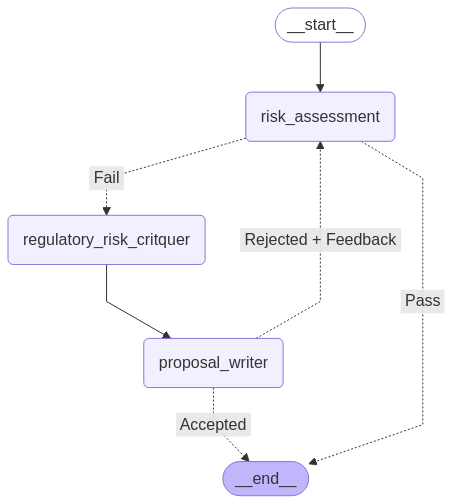

In [8]:
# Compile
memory = MemorySaver()
chain = workflow.compile(checkpointer=memory)

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [9]:
# Invoke
user_prompt = "This proposed FDA label describes Respilimab, a humanized monoclonal antibody \
    targeting IL-13, for treatment of moderate-to-severe eosinophilic asthma. It outlines dosing \
        (300 mg subcutaneous every 4 weeks), safety data, and trial outcomes showing improved lung \
            function and reduced exacerbations, supporting use in patients uncontrolled on standard inhaled therapies."


config = {"configurable": {"thread_id": "2"}}
print(config['configurable'])
#state = chain.invoke({"user_proposal": user_prompt}, config)



{'thread_id': '2'}


In [12]:
#state = chain.invoke({"user_proposal": user_prompt}, config)


In [11]:
# # Start conversation
for chunk in chain.stream({"user_proposal": user_prompt}, config, stream_mode="updates"):
    print(chunk)
    #chunk['risk_assessment']["risk_assessment_and_rating"].pretty_print()
    #chunk['regulatory_risk_critquer']["proposal_feedback"].pretty_print()
    #chunk['proposal_writer']["improved_proposal"].pretty_print()
    #chunk['llm_call_evaluator']["feedback"].pretty_print()

{'risk_assessment': {'pass_or_fail': 'fail', 'risk_assessment_and_rating': "Overall Rating: 2/10\nThe following are specific issues with the proposal:\n1. Lack of detailed clinical trial data analysis: The proposal mentions that trial outcomes show improved lung function and reduced exacerbations, but it does not provide a clear explanation or statistical analysis of these results.\n2. No discussion of potential side effects: The proposal does not address potential side effects of Respilimab, such as infusion reactions, hypertension, or hyperkalemia, which could be significant concerns for patients.\n3. Inadequate comparison to existing treatments: The proposal does not adequately compare the efficacy and safety of Respilimab to existing inhaled therapies for asthma, making it difficult to justify its use in clinical practice.\n4. No discussion of patient population demographics: The proposal does not provide information on the demographics of the patients enrolled in the clinical tria

In [34]:
print("Initial review:")
print(state["risk_assessment_and_rating"])
print("\n--- --- ---\n")
if "proposal_feedback" in state:
    print("proposal_feedback:")
    print(state["proposal_feedback"])
    print("\n--- --- ---\n")

    print("improved_proposal:")
    print(state["improved_proposal"])
    print("grade:")
    print(state["pass_or_fail"])
else:
    print("Proposal failed quality gate - lower than 5 threshold!")
    
    

Initial review:
**Risk Assessment and Regulatory Review**

**Overall Rating: 6/10**

The proposed FDA label for Respilimab presents some strengths, but also identifies several concerns that may impact regulatory approval.

**Strengths:**

1. **Clinical trial data**: The submission includes results from a pivotal clinical trial demonstrating improved lung function and reduced exacerbations in patients with moderate-to-severe eosinophilic asthma.
2. **Clear dosing instructions**: The proposed label outlines a clear dosing regimen, which is essential for ensuring safe and effective use of the treatment.

**Flaws:**

1. **Lack of detailed mechanism of action**: While the label mentions that Respilimab targets IL-13, it does not provide sufficient information on how this mechanism will prevent or treat asthma exacerbations.
2. **Insufficient discussion of potential side effects**: The submission does not adequately address potential side effects associated with monoclonal antibody therapy, 